In [1]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

#define the number of clusters
n_cms_ip_cluster = 20

In [2]:
feature_data = pd.read_csv('Demo_CMS_IP_features_columns_10000.csv')

In [3]:
feature_data.dtypes
feature_data.head(3)

DESYNPUF_ID                        object
CLM_ID                              int64
SEGMENT                             int64
CLM_FROM_DT                        object
CLM_THRU_DT                        object
PRVDR_NUM                          object
CLM_PMT_AMT                       float64
NCH_PRMRY_PYR_CLM_PD_AMT          float64
AT_PHYSN_NPI                      float64
OP_PHYSN_NPI                      float64
OT_PHYSN_NPI                      float64
CLM_ADMSN_DT                       object
ADMTNG_ICD9_DGNS_CD                object
CLM_PASS_THRU_PER_DIEM_AMT        float64
NCH_BENE_IP_DDCTBL_AMT            float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM    float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    float64
CLM_UTLZTN_DAY_CNT                  int64
NCH_BENE_DSCHRG_DT                  int64
CLM_DRG_CD                         object
ICD9_DGNS_CD_1                     object
ICD9_DGNS_CD_2                     object
ICD9_DGNS_CD_3                     object
ICD9_DGNS_CD_4                    

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,BENE_Age_Group
0,00013D2EFD8E45D1,196661176988405,1,2010-03-12,2010-03-13,2600GD,4000.0,0.0,3.139084e+09,NaN,...,0.0,0.0,0.0,50.0,10.0,0.0,0.0,0.0,0.0,4.0
1,00016F745862898F,196201177000368,1,2009-04-12,2009-04-18,3900MB,26000.0,0.0,6.476809e+09,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,700.0,240.0,0.0,3.0
2,00016F745862898F,196661177015632,1,2009-08-31,2009-09-02,3900HM,5000.0,0.0,6.119985e+08,611998537.0,...,0.0,0.0,0.0,0.0,0.0,0.0,700.0,240.0,0.0,3.0


In [4]:
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT','PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_SEX_IDENT_CD','BENE_RACE_CD','BENE_ESRD_IND', 'BENE_COUNTY_CD', 'SP_STATE_CODE',
                  'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

In [5]:
feature_data.describe(include='all')
#data['ICD9_DGNS_CD_1'].head(10)
#data['ICD9_PRCDR_CD_1'].head(10)


,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,BENE_Age_Group
count,9984,9.984000e+03,9984.0,9984,9984,9984,9984.000000,9984.000000,9.908000e+03,5.828000e+03,...,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000
unique,5622,NaN,NaN,1099,1088,1842,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,019E4729585EF3DD,NaN,NaN,2008-07-24,2008-06-02,23006G,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,11,NaN,NaN,23,25,125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.965023e+14,1.0,NaN,NaN,NaN,9501.324119,438.010817,5.019069e+09,5.149653e+09,...,12706.753806,1374.964543,714.122596,1548.319311,486.218950,77.973758,2827.805489,766.728766,44.731571,3.664163
std,NaN,2.861480e+11,0.0,NaN,NaN,NaN,9211.635289,3694.872532,2.916123e+09,2.933019e+09,...,19231.105364,1945.329665,5065.451295,3106.412887,871.856803,655.375977,2469.790398,634.587810,150.686193,0.732124
min,NaN,1.960112e+14,1.0,NaN,NaN,NaN,-3000.000000,0.000000,3.320659e+06,1.159725e+06,...,-3000.000000,0.000000,0.000000,-40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,1.962512e+14,1.0,NaN,NaN,NaN,4000.000000,0.000000,2.478422e+09,2.588811e+09,...,0.000000,0.000000,0.000000,90.000000,20.000000,0.000000,1050.000000,300.000000,0.000000,3.000000
50%,NaN,1.965012e+14,1.0,NaN,NaN,NaN,7000.000000,0.000000,4.965742e+09,5.150433e+09,...,5000.000000,1024.000000,0.000000,560.000000,180.000000,0.000000,2260.000000,620.000000,0.000000,4.000000
75%,NaN,1.967512e+14,1.0,NaN,NaN,NaN,11000.000000,0.000000,7.584837e+09,7.751198e+09,...,18000.000000,2048.000000,0.000000,1720.000000,570.000000,0.000000,3950.000000,1080.000000,20.000000,4.000000


In [6]:
#feature_data.Other_proc.value_counts()

In [7]:
# Scale KPIs

KPI_COLUMNS = ['CLM_PMT_AMT']    
SCALED_KPI_COLUMNS = ['SCALED_CLM_PMT_AMT']
#scaler = RobustScaler(quantile_range=(25, 75))
scaler = MinMaxScaler()
scaled_kpi_data = pd.DataFrame(scaler.fit_transform(feature_data[KPI_COLUMNS]), columns=SCALED_KPI_COLUMNS)
scaled_kpi_data.head(10)

,SCALED_CLM_PMT_AMT
0,0.116667
1,0.483333
2,0.133333
3,0.133333
4,0.316667
5,0.283333
6,0.133333
7,0.133333
8,0.283333
9,0.533333


In [8]:
# Create "Orig Cluster Data" with all original KPIs

orig_cluster_data = feature_data.drop(EXCLUDE_COLUMNS, axis=1)

scaled_cluster_data = orig_cluster_data

In [9]:
# Create "Cluster Data" with scaled KPIs
a = orig_cluster_data.copy()
b = scaled_kpi_data.copy()
a.reset_index(drop=True, inplace=True)
b.reset_index(drop=True, inplace=True)
scaled_cluster_data = pd.concat([a,b], axis=1)
scaled_cluster_data.head(3)
scaled_cluster_data.dtypes

,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,proc_9904,proc_8154,proc_3893,...,CLM_FROM_Year,CLM_FROM_Month,CLM_FROM_Day,CLM_FROM_DOW,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,BENE_Age_Group,SCALED_CLM_PMT_AMT
0,4000.0,0.0,0.0,1100.0,0.0,0.0,1,0,0,0,...,2010,3,12,4,12,12,12,12,4.0,0.116667
1,26000.0,0.0,0.0,1068.0,0.0,0.0,6,0,0,0,...,2009,4,12,6,12,12,0,0,3.0,0.483333
2,5000.0,0.0,0.0,1068.0,0.0,0.0,2,0,0,0,...,2009,8,31,0,12,12,0,0,3.0,0.133333


CLM_PMT_AMT                           float64
NCH_PRMRY_PYR_CLM_PD_AMT              float64
CLM_PASS_THRU_PER_DIEM_AMT            float64
NCH_BENE_IP_DDCTBL_AMT                float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM        float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM        float64
CLM_UTLZTN_DAY_CNT                      int64
proc_9904                               int64
proc_8154                               int64
proc_3893                               int64
proc_66                                 int64
proc_3995                               int64
proc_4516                               int64
proc_3722                               int64
proc_9671                               int64
proc_8872                               int64
proc_8151                               int64
proc_4513                               int64
proc_9390                               int64
proc_9672                               int64
proc_7935                               int64
proc_5123                         

In [10]:
#scaled_cluster_data_cms_ip = scaled_cluster_data.loc[lambda scaled_cluster_data: scaled_cluster_data.cms_ip ==1,:]
scaled_cluster_data_cms_ip = scaled_cluster_data

In [11]:
def cluster_model(n_cluster):
#    model = AgglomerativeClustering(n_clusters=n_cluster,linkage="complete", affinity="cosine")
#    model = AgglomerativeClustering(n_clusters=n_cluster,linkage="complete", affinity="manhattan")
    model = KMeans(n_clusters=n_cluster, random_state=0)
    return model

# cms_ip Cluster

In [12]:
scaled_cluster_data_cms_ip.head(3)

,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,proc_9904,proc_8154,proc_3893,...,CLM_FROM_Year,CLM_FROM_Month,CLM_FROM_Day,CLM_FROM_DOW,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,BENE_Age_Group,SCALED_CLM_PMT_AMT
0,4000.0,0.0,0.0,1100.0,0.0,0.0,1,0,0,0,...,2010,3,12,4,12,12,12,12,4.0,0.116667
1,26000.0,0.0,0.0,1068.0,0.0,0.0,6,0,0,0,...,2009,4,12,6,12,12,0,0,3.0,0.483333
2,5000.0,0.0,0.0,1068.0,0.0,0.0,2,0,0,0,...,2009,8,31,0,12,12,0,0,3.0,0.133333


In [13]:
n_cms_ip_cluster = 20
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT','PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_SEX_IDENT_CD','BENE_RACE_CD','BENE_ESRD_IND', 'BENE_COUNTY_CD', 'SP_STATE_CODE',
                  'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

In [14]:
cms_ip_cluster_output = scaled_cluster_data_cms_ip.copy()
ready_cluster_data_cms_ip = scaled_cluster_data_cms_ip.drop(KPI_INDEX_COLUMNS, axis=1)
X_cms_ip = ready_cluster_data_cms_ip.values
X_cms_ip[0:3,:]
X_cms_ip.shape
#ready_cluster_data_cms_ip.Other_proc.value_counts()
ready_cluster_data_cms_ip.head(3)

array([[ 0.        ,  0.        ,  0.        , ..., 12.        ,
         4.        ,  0.11666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.        ,  0.48333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.        ,  0.13333333]])

(9984, 477)

,proc_9904,proc_8154,proc_3893,proc_66,proc_3995,proc_4516,proc_3722,proc_9671,proc_8872,proc_8151,...,dx_42841,dx_4439,dx_3843,dx_OTHER_DX,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,BENE_Age_Group,SCALED_CLM_PMT_AMT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,12,12,12,12,4.0,0.116667
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,12,12,0,0,3.0,0.483333
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,12,12,0,0,3.0,0.133333


In [15]:
#cms_ip_cluster_output = scaled_cluster_data_cms_ip.copy()
#ready_cluster_data_cms_ip = scaled_cluster_data_cms_ip.drop(KPI_INDEX_COLUMNS, axis=1)
#X_cms_ip = ready_cluster_data_cms_ip.values
model_cms_ip = cluster_model(n_cms_ip_cluster)
model_cms_ip.fit(X_cms_ip)
label_cms_ip = model_cms_ip.labels_
cms_ip_cluster_output["cluster"] = label_cms_ip
cms_ip_cluster_output.to_csv("cms_ip_cluster_output.csv")

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [16]:
cms_ip_cluster_output["cluster"].value_counts()

6     2408
2     2091
5     2037
0     1304
13     852
1      477
8      157
16     126
19      89
17      78
15      55
10      52
4       48
11      45
12      40
7       35
14      35
9       23
18      16
3       16
Name: cluster, dtype: int64

In [17]:
cms_ip_cluster_output.head(1)

,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,proc_9904,proc_8154,proc_3893,...,CLM_FROM_Month,CLM_FROM_Day,CLM_FROM_DOW,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,BENE_Age_Group,SCALED_CLM_PMT_AMT,cluster
0,4000.0,0.0,0.0,1100.0,0.0,0.0,1,0,0,0,...,3,12,4,12,12,12,12,4.0,0.116667,2


In [18]:
#evaluate clusters
print(metrics.silhouette_score(X_cms_ip, label_cms_ip, metric='euclidean'))
print(metrics.calinski_harabaz_score(X_cms_ip, label_cms_ip))

0.19723844300530308
6620.681082080894


PCA Visualization

(9984, 3)


[]

[]

[]

Text(0.5,0,'PCA 1')

Text(0.5,0,'PCA 2')

Text(0.5,0,'PCA 3')

Text(0.5,0.92,'AC clusters on PCA')

(9984, 2)


No handles with labels found to put in legend.


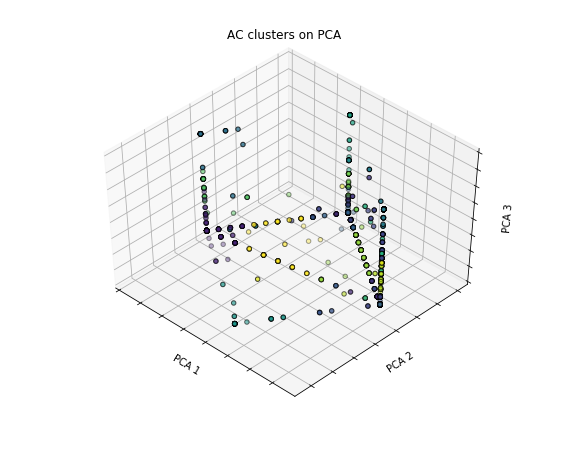

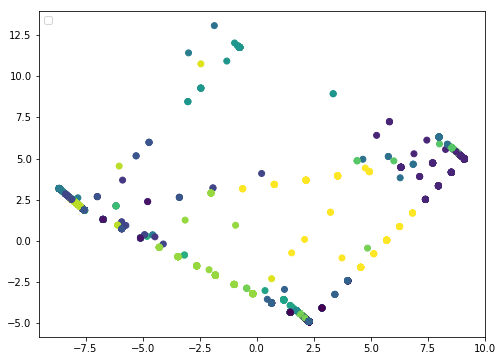

In [19]:
from sklearn import decomposition
# Import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
PC = decomposition.PCA(n_components=3).fit_transform(ready_cluster_data_cms_ip.values)
print(PC.shape)
fig = plt.figure(1, figsize=(8, 6))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
#use the cluster membership as labels
ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2],
               c=label_cms_ip, edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title("AC clusters on PCA")
ax.dist = 12


PC2 = decomposition.PCA(n_components=2).fit_transform(ready_cluster_data_cms_ip.values)
print(PC2.shape)
fig2 = plt.figure(2, figsize=(8, 6))
plt.scatter(PC[:,0],PC[:,1],c=label_cms_ip)
plt.legend(loc=2)


# TSNE Visualization. Reset Kernel

In [20]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

In [21]:
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT','PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_SEX_IDENT_CD','BENE_RACE_CD','BENE_ESRD_IND', 'BENE_COUNTY_CD', 'SP_STATE_CODE',
                  'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

In [22]:
KPI_INDEX_COLUMNS.append('cluster')
KPI_INDEX_COLUMNS

['CLM_PMT_AMT',
 'NCH_PRMRY_PYR_CLM_PD_AMT',
 'CLM_PASS_THRU_PER_DIEM_AMT',
 'NCH_BENE_IP_DDCTBL_AMT',
 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 'CLM_UTLZTN_DAY_CNT',
 'LOG_CLM_PMT_AMT',
 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT',
 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
 'LOG_NCH_BENE_IP_DDCTBL_AMT',
 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 'CLM_FROM_Year',
 'CLM_FROM_Month',
 'CLM_FROM_Day',
 'CLM_FROM_DOW',
 'cluster']

In [23]:
def tsne_viz(tsne_data,KPI_INDEX_COLUMNS):

    Y = tsne_data["cluster"].values
    tsne_data_x = tsne_data.iloc[:,1:]
    X = tsne_data_x.drop(KPI_INDEX_COLUMNS, axis=1).values
    
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne_reduced = tsne.fit_transform(X)
    
    return X_tsne_reduced, Y

# TSNE Visualization: cms_ip Cluster

<Figure size 936x720 with 0 Axes>

(-77.63406352697076, 73.6019895523614, -66.19182713279135, 53.86576588401205)

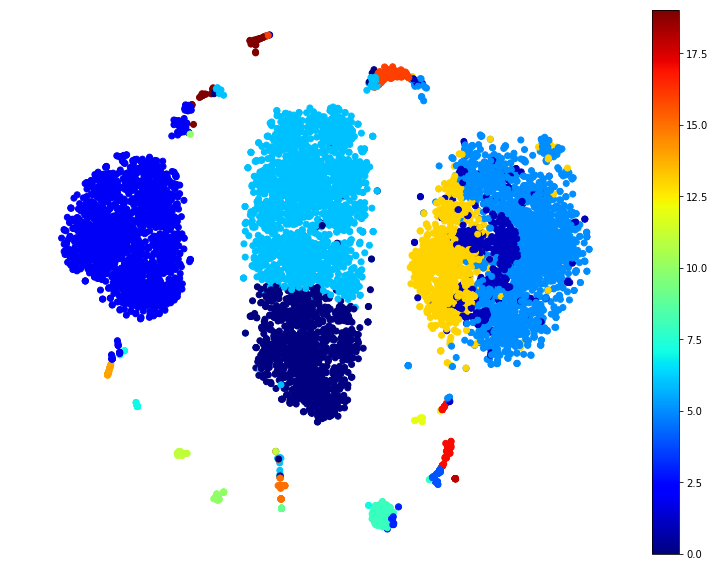

In [24]:
input_file = "cms_ip_cluster_output.csv"

output_file = "cms_ip_tsne_cluster_output.csv"

tsne_cluster_data = pd.read_csv(input_file)
X_pca_tsne_reduced, Y = tsne_viz(tsne_cluster_data,KPI_INDEX_COLUMNS)    

plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1],c=Y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

tsne_cluster_data['TSNE1'] = X_pca_tsne_reduced[:, 0]
tsne_cluster_data['TSNE2'] = X_pca_tsne_reduced[:, 1]
tsne_cluster_data.to_csv(output_file)

# Random Forest Explanation

# Reset Kernel

In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [26]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

#define the number of clusters
n_cms_ip_cluster = 20

ModuleNotFoundError: No module named 'h2o'

In [4]:
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

In [5]:
KPI_INDEX_COLUMNS.append('cluster')
KPI_INDEX_COLUMNS

[u'CLM_PMT_AMT',
 u'NCH_PRMRY_PYR_CLM_PD_AMT',
 u'CLM_PASS_THRU_PER_DIEM_AMT',
 u'NCH_BENE_IP_DDCTBL_AMT',
 u'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_UTLZTN_DAY_CNT',
 u'LOG_CLM_PMT_AMT',
 u'LOG_NCH_PRMRY_PYR_CLM_PD_AMT',
 u'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
 u'LOG_NCH_BENE_IP_DDCTBL_AMT',
 u'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_FROM_Year',
 u'CLM_FROM_Month',
 u'CLM_FROM_Day',
 u'CLM_FROM_DOW',
 u'cluster']

# Explanation: cms_ip Clusters. Delete the rfout file.

In [1]:
'''cluster_cms_ip = pd.read_csv('cms_ip_cluster_output.csv')
cluster_cms_ip_x = cluster_cms_ip.iloc[:,1:]
cluster_cms_ip_predictors = cluster_cms_ip_x.drop(KPI_INDEX_COLUMNS, axis=1)
label_cms_ip = cluster_cms_ip["cluster"].values
ntree=  500
depth = 30
nfold = 10
#tempoutput = pd.DataFrame(columns=['variable','relative_importance','scaled_importance','percentage','cluster_member','data_segment'])
output_file = open('rfout_cms_ip.csv','a')
for i in range(n_cms_ip_cluster):
    rf_cms_ip_model = H2ORandomForestEstimator(ntrees=ntree, max_depth=depth, nfolds=nfold)
    predictors= cluster_cms_ip_predictors.columns.values.tolist()
    response = "cluster"
    classlabels = np.where(label_cms_ip==i,1,0)
    rf_df = h2o.H2OFrame(cluster_cms_ip_predictors)
    rf_df.set_names(predictors)
    rf_df[response]=h2o.H2OFrame(classlabels)
    train,valid = rf_df.split_frame(ratios = [0.8], seed=42)
    rf_cms_ip_model.train(x=predictors,y=response, training_frame = train, validation_frame = valid)
    output_df = rf_cms_ip_model._model_json['output']['variable_importances'].as_data_frame()
    output_df["cluster_member"] = i
    output_df["data_segment"] = "cms_ip"
    output_df
    if i==1:
        output_df.to_csv(output_file, header=True)
    else:
        output_df.to_csv(output_file, header=False)

output_file.close()'''

'cluster_cms_ip = pd.read_csv(\'cms_ip_cluster_output.csv\')\ncluster_cms_ip_x = cluster_cms_ip.iloc[:,1:]\ncluster_cms_ip_predictors = cluster_cms_ip_x.drop(KPI_INDEX_COLUMNS, axis=1)\nlabel_cms_ip = cluster_cms_ip["cluster"].values\nntree=  500\ndepth = 30\nnfold = 10\n#tempoutput = pd.DataFrame(columns=[\'variable\',\'relative_importance\',\'scaled_importance\',\'percentage\',\'cluster_member\',\'data_segment\'])\noutput_file = open(\'rfout_cms_ip.csv\',\'a\')\nfor i in range(n_cms_ip_cluster):\n    rf_cms_ip_model = H2ORandomForestEstimator(ntrees=ntree, max_depth=depth, nfolds=nfold)\n    predictors= cluster_cms_ip_predictors.columns.values.tolist()\n    response = "cluster"\n    classlabels = np.where(label_cms_ip==i,1,0)\n    rf_df = h2o.H2OFrame(cluster_cms_ip_predictors)\n    rf_df.set_names(predictors)\n    rf_df[response]=h2o.H2OFrame(classlabels)\n    train,valid = rf_df.split_frame(ratios = [0.8], seed=42)\n    rf_cms_ip_model.train(x=predictors,y=response, training_frame 

In [7]:
h2o.cluster().shutdown()

H2O session _sid_8777 closed.


In [9]:
output_df.shape

(438, 6)

In [10]:
cluster_cms_ip_predictors.shape

(1997, 477)